In [1]:
%cd /home/anthony/projects/skmob_mmc_mobility/

/home/anthony/projects/skmob_mmc_mobility


In [2]:
import json
import os
import shutil
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append( '/home/anthony/projects/skmob_mmc_mobility/programs')

from matplotlib.pyplot import title
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm

from config import PATH_LOCAL_DATA, PATH_S3_EXPERIMENTS
from gan_utils.dpgan_tf2 import DPGAN
from gan_utils.gan_tf3 import GAN
from gan_utils.gan_utils import (get_optimizers, 
                                get_data, 
                                get_generated_data, 
                                get_data_user_conjoined, 
                                plot_user_geodata)
from gan_utils.s3_utils import upload_file_to_s3                            

warnings.filterwarnings('ignore')

2022-05-11 08:46:12.237139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-11 08:46:12.237186: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2022-05-11 08:46:13.918061: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (100)
2022-05-11 08:46:13.918119: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-0C6FICR): /proc/driver/nvidia/version does not exist


In [4]:
path_data = os.path.join(PATH_LOCAL_DATA, 'users')
path_output= os.path.join(PATH_LOCAL_DATA, 'users_gan')
filename = 'data_user_006.csv'
nepochs = 2000
param = {'batch_size': 256,
            'discriminatorDims': [64, 32, 16, 1],
            'generatorDims': [512,16, 3],
            'input_dim': 3,
            'optimizer': 'Adam',
            'random_dim': 100
            }
upload_to_s3 = False
scale_data = False

In [5]:
start_time = time.time()


In [6]:
for path in [path_data, path_output]:
    if not os.path.exists(path):
        os.mkdir(path)

In [7]:
file_path = os.path.join(path_data, filename)

data = pd.read_csv(file_path)

In [8]:
# Reduce to a sample
max_sample = 5000
if data.shape[0]>max_sample:
    data = data.sample(max_sample)


In [9]:
# Days of the week in the dataset
pd.to_datetime(data.time, errors = 'coerce', format='%Y-%m-%d').dt.dayofweek.value_counts()

3    1715
4    1677
2    1446
0     115
1      47
Name: time, dtype: int64

In [10]:
data.head()

,time,lat,lon,user
7624,2008-11-19 15:42:38,39.976557,116.339276,6
482,2008-10-24 11:00:43,39.963124,116.346945,6
14119,2008-12-04 15:08:03,39.813699,116.269788,6
8028,2008-11-19 21:58:54,39.980280,116.326072,6
3118,2008-11-12 00:45:13,39.983743,116.345636,6


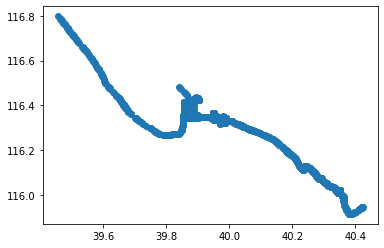

In [11]:
plt.scatter(data = data[['lat','lon']], x ='lat', y ='lon')

In [12]:
# Training
g_optimizer, d_optimizer = get_optimizers(param["optimizer"])

In [13]:
dp = GAN(
    param["input_dim"],
    param["random_dim"],
    param["discriminatorDims"],
    param["generatorDims"],
    g_optimizer,
    d_optimizer
)
d_dims = '_'.join([str(x) for x in param["discriminatorDims"]])
g_dims = '_'.join([str(x) for x in param["generatorDims"]])
bsize = str(param["batch_size"])

generator created...
discriminator created...


2022-05-11 08:46:14.783602: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
data_conjoint, user_conjoint = get_data_user_conjoined(data)

In [15]:
# Scale if necessary
data_scaled = get_data(data_conjoint)

In [16]:
#dataset = tf.data.Dataset.from_tensor_slices(data_scaled).shuffle(50000).batch(param["batch_size"], drop_remainder=True)
print(pd.DataFrame(data_scaled).head())
dataset = tf.convert_to_tensor(pd.DataFrame(data_scaled))

       time-f        lat         lon     lat_sqrd      lon_sqrd  lat_lon_sqrd
7624       15  39.976557  116.339276  1598.125110  13534.827140  15132.952250
482        11  39.963124  116.346945  1597.051280  13536.611611  15133.662891
14119      15  39.813699  116.269788  1585.130628  13518.663602  15103.794230
8028       21  39.980280  116.326072  1598.422789  13531.755027  15130.177816
3118        0  39.983743  116.345636  1598.699704  13536.307016  15135.006721


G loss:  0.0  D loss:  6179.381  step:  0
[ 39.976557  39.963124  39.813699 ... 116.327926 116.309611 116.345982]
[-71.53235   -60.26691   -69.59404   ...  -8.001831   -7.8986244
  -7.0604897]


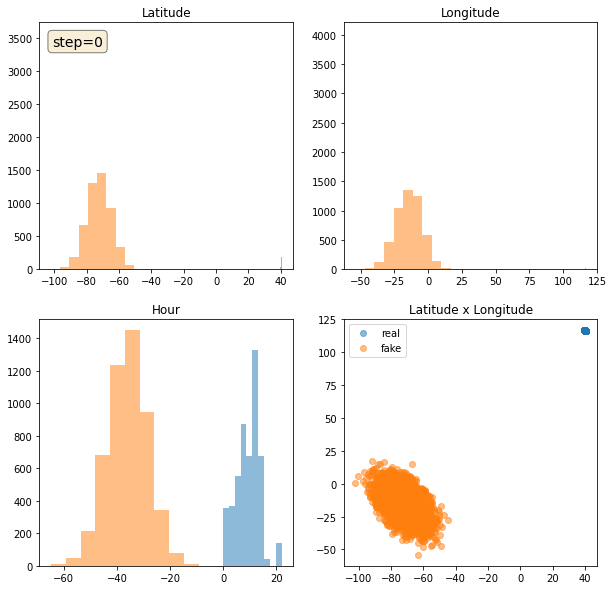

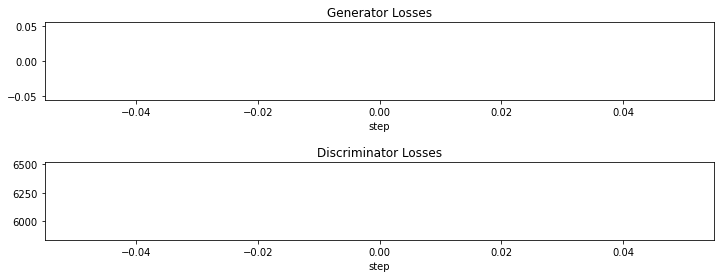

G loss:  7.8829923  D loss:  11131.4795  step:  100
[ 39.976557  39.963124  39.813699 ... 116.327926 116.309611 116.345982]
[ 0.21276723  3.0309148   1.804547   ... -0.34610072  0.5098105
 -2.4912844 ]


<Figure size 432x288 with 0 Axes>

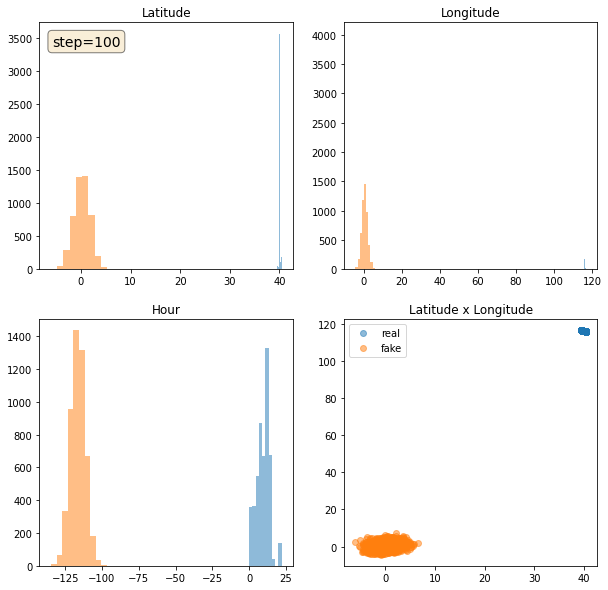

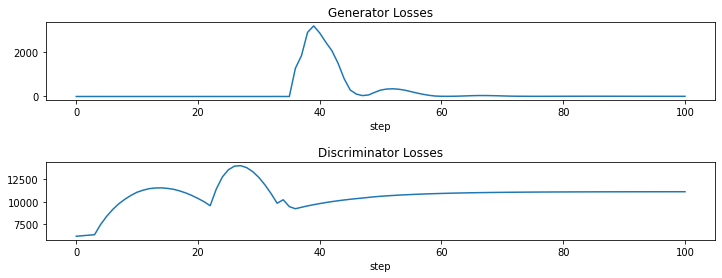

G loss:  5.5286884  D loss:  13169.288  step:  200
[ 39.976557  39.963124  39.813699 ... 116.327926 116.309611 116.345982]
[-0.07763036  0.28944463  0.8089511  ... -2.218318   -0.9180365
  0.2925691 ]


<Figure size 432x288 with 0 Axes>

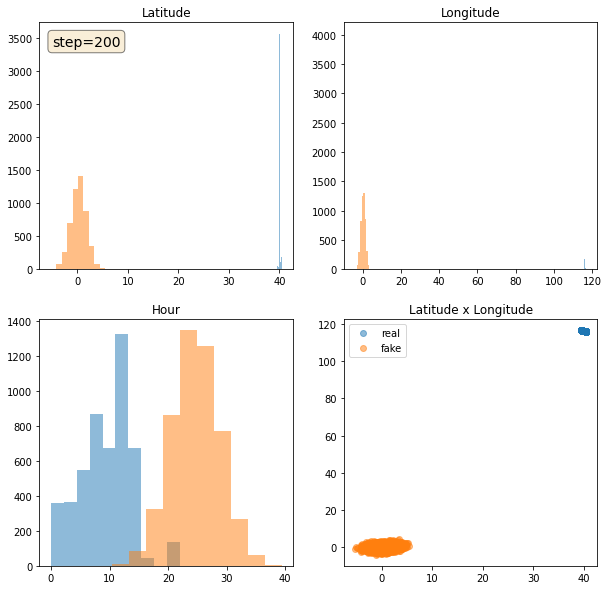

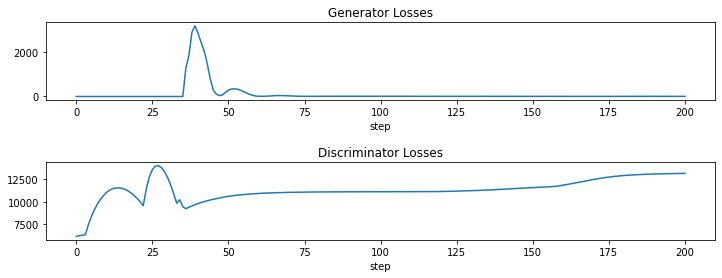

In [17]:
results = dp.train(dataset, nepochs, param["batch_size"])